# Sentiment Analysis of Movie Reviews

Pytorch implementation of Sentiment Analysis of long textual movie reviews written in Serbian language (which is underused language) using pretrained multinigual Roberta based language model [XLM-R](https://ai.facebook.com/blog/-xlm-r-state-of-the-art-cross-lingual-understanding-through-self-supervision/). Dataset is balanced and it consits of 1684 **positive** and **negative** reviews, and it can be found [here](https://github.com/vukbatanovic/SerbMR). This balanced dataset is a subset of unbalanced set of 4725 movie reviews. Reviews have scoring metric which ranges from 1 to 10. Scores from 1-4 are treated as negative, 5-6 as neutral and 7-10 as positive. So some reviews have very weak sentiment and are very hard to classify correctly even by humans. 

## Connect to google drive

Connect to Google Drive so that you can read the data and save checkpoints.

In [ ]:
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


Change to directory where the notebook is located in the drive

In [ ]:
%cd /content/google_drive/MyDrive/Colab\ Notebooks/Sentiment-Analysis-Roberta
%ls

## Load the data

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = os.path.join(os.getcwd(),'data')
movies_path = os.path.join(data_path,'Movie-Reviews')
df = pd.read_csv(os.path.join(movies_path,'SerbMR-2C.csv'))
df.rename(columns={'class-att':'Label'},inplace=True)
df.head()

,Text,Label
0,Braća Koen (Coen brothers) iako poznati po tri...,POSITIVE
1,Često upadam u veliku raspravu kada se izjasni...,POSITIVE
2,“Ulični Psi” je jedan od onih filmova koji sve...,POSITIVE
3,Užasno potcenjen film! Predvođen dvojicom najp...,POSITIVE
4,"Naprosto sam oduševljen ovim projektom, ovo je...",POSITIVE


Example of a movie review

In [ ]:
EXAMPLE_NUM =   0#@param {type: 'integer'}
[print(x+'.') for x in df.Text.iloc[EXAMPLE_NUM].split('.')]
print('')

Braća Koen (Coen brothers) iako poznati po trilerima, oprobali su se više puta i u komedija, i postigli potpuni uspeh.
 Ovaj film, pošto je kada se pojavio bio vrlo loše prihvaćen, nije nažalost uspeo da zablista po američkim bioskopima, ali je zato bio prava senzacija kad se pojavio na DVD-u i na osnovu toga, postao jedan od glavnih naslova u kolekciji svakog pravog filmofila.
 „The Big Lebowski“ definitvno moj omiljeni film i jedino ostvarenje koje zaista uvek iznova i iznova mogu da gledam.
 On predstavlja odu životnom stilu jednog pacifiste.
 „The Big Lewbowski“ je klasična priča prevare, kriminala i spletkarenja viđena kroz oči skromnog čoveka, tačnije jednostavne individue sa vrlo malo prohteva, želja i ambicija.
 Žanr ovog filma nije lako odrediti – može se reći da je komedija zbog svog izuzetno originalnog humorističkog sadržaja.
 Bogat fantastičnim likovima i još boljim dijalozima, koji iako su se transformisali u besmrtne citate koji se koriste u svakodnevnom životu, „The Big

##  Split into train, test and val set

Ratio: (80%-10%-10%) - (train - val - test)

In [ ]:
def split_df(df):
    n_rows = len(df)
    ind = np.random.permutation(n_rows)
    df = df.iloc[ind,:]
    df_train = df.iloc[:int(0.8*n_rows),:]
    df_val = df.iloc[int(0.8*n_rows):int(0.9*n_rows),:]
    df_test = df.iloc[int(0.9*n_rows):,:]

    return df_train, df_val, df_test

In [ ]:
n_rows = len(df)
dfs_train, dfs_val, dfs_test = [],[],[]
gb = df.groupby('Label')
for x in gb.groups:
    group = gb.get_group(x)
    df_train, df_val, df_test = split_df(group)
    dfs_train.append(df_train)
    dfs_val.append(df_val)
    dfs_test.append(df_test) 
df_train = pd.concat(dfs_train, ignore_index=True)
ind = np.random.permutation(len(df_train))
df_train = df_train.iloc[ind,:]
df_val = pd.concat(dfs_val, ignore_index=True)
ind = np.random.permutation(len(df_val))
df_val = df_val.iloc[ind,:]
df_test = pd.concat(dfs_test, ignore_index=True)
ind = np.random.permutation(len(df_test))
df_test = df_test.iloc[ind,:]
print(f'Number of training examples: {len(df_train)}')
print(f'Number of validation examples: {len(df_val)}')
print(f'Number of test examples: {len(df_test)}')

Number of training examples: 1344
Number of validation examples: 168
Number of test examples: 170


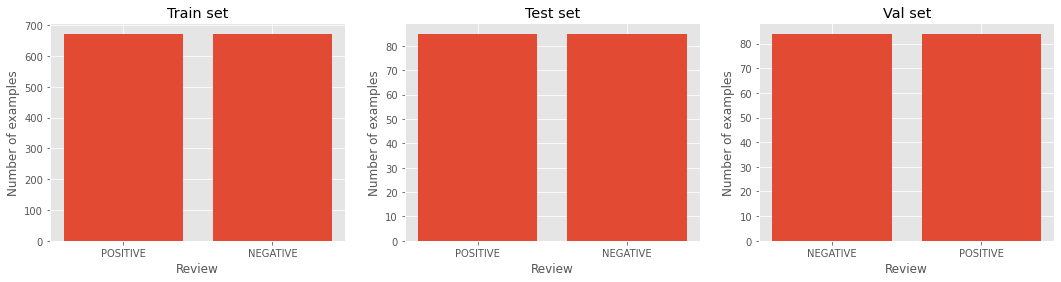

In [ ]:
fig = plt.figure(figsize=(18,4))
titles = ['Train set','Test set','Val set']
for i,dataf in enumerate([df_train,df_test,df_val]):
    ax = fig.add_subplot(1,3,i+1)
    Y, labels = pd.factorize(dataf['Label'])
    ax.bar(labels, height=pd.Series(Y).value_counts())
    ax.set_xticks(ticks=range(len(labels)))
    ax.set_xticklabels(labels,fontsize=10)
    ax.set_xlabel('Review')
    ax.set_ylabel('Number of examples')
    ax.set_title(titles[i])

## Load XLM-R model

Since the Facebook researchers are the creators of the model, the model can be found in fairseq package. So we need to install dependencies for fairseq and download the model from pytorch hub. We also need to install transformer package, because we will be using advanced optimizers and learning rate schedulers.

In [ ]:
%pip install hydra-core
%pip install omegaconf
%pip install sentencepiece
%pip install transformers

Load XLM-R model and sentencepiece tokenizer

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from statistics import mean
import pickle
from transformers import XLMRobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.optim import SGD

BASE (2 times smaller than large)


In [ ]:
xlmr = torch.hub.load('pytorch/fairseq', 'xlmr.base')
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

Wrap tokenizer by specifing its hyperparametrs

In [ ]:
def wrap_tokenizer(tokenizer, padding=True, truncation=True, return_tensors='pt', max_length=None):
    def tokenize(text):
        text = list(text)
        tokens = tokenizer(
            text,
            padding=padding, 
            return_attention_mask=False,
            truncation=truncation,
            max_length=max_length,
            return_tensors=return_tensors
            )['input_ids']
        return tokens
    return tokenize

## Determine the distribution of number of tokens of texts

Since we are dealing with large texts which probably can not fit into the XLM-R model (which is around 512), so we will examine the distribution of number of tokens of texts to see how we can split the text to fit into our model.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


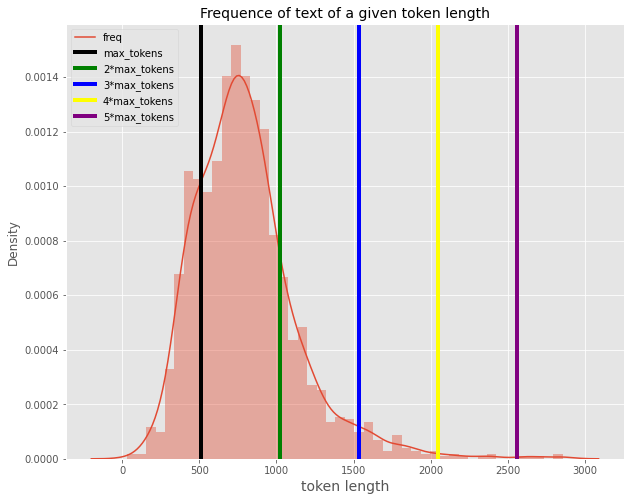

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

tokenize = wrap_tokenizer(tokenizer, padding=False, truncation = False, return_tensors=None)
tokens = tokenize(df['Text'])
num_tokens = [len(x) for x in tokens]
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
df['length'] = pd.Series(num_tokens)
sns.distplot(df['length'])
plt.title('Frequence of text of a given token length', fontsize=14)
plt.xlabel('token length', fontsize=14)
plt.axvline(x=512,linewidth=4,color='black')
plt.axvline(x=2*512,linewidth=4,color='green')
plt.axvline(x=3*512,linewidth=4,color='blue')
plt.axvline(x=4*512,linewidth=4,color='yellow')
plt.axvline(x=5*512,linewidth=4,color='purple')
plt.legend(['freq','max_tokens','2*max_tokens','3*max_tokens','4*max_tokens','5*max_tokens'])

In [ ]:
max_tokens = 512 # 512
for i in range(1,6):
    num = sum(df['length']>i*max_tokens)
    print(f"Number of text that have more than {i}*max_tokens is {num}")

Number of text that have more than 1*max_tokens is 1355
Number of text that have more than 2*max_tokens is 320
Number of text that have more than 3*max_tokens is 62
Number of text that have more than 4*max_tokens is 13
Number of text that have more than 5*max_tokens is 5


We can see that 1355 examples out of 1682 would not fit into our model. So we will need to split the text into multiple chunks and input each chunk separately through the model. After we get the vector representations of context of each chunk we will join them into one with LSTM layer (there are various ways to do this, for example the easiest way would be to perform sum or average pooling on the contexts). I have chosen the LSTM out of learning purposes.

In [ ]:
def get_text_split(text, length=200, overlap=50, max_chunks=4):
    l_total = []
    l_parcial = []
    n_words = len(text.split()) 
    n = n_words//(length-overlap)+1 # n is number of splits
    if n_words % (length-overlap) == 0:
        n = n-1
    if n ==0:
        n = 1
    n = min(n, max_chunks)
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:length]
        else:
            l_parcial = text.split()[w*(length-overlap):w*(length-overlap) + length]
        l = " ".join(l_parcial)
        if w==n-1:
            if len(l_parcial) < 0.75*length and n!=1: # keep the last if it has 75% of length
                continue
        l_total.append(l)
    return l_total

In [ ]:
df_train.Text = df_train.Text.apply(lambda x: get_text_split(x))
df_val.Text = df_val.Text.apply(lambda x: get_text_split(x))
df_test.Text = df_test.Text.apply(lambda x: get_text_split(x))

In [ ]:
df_train['n_chunks'] = df_train.Text.apply(lambda x: len(x))
df_val['n_chunks'] = df_val.Text.apply(lambda x: len(x))
df_test['n_chunks'] = df_test.Text.apply(lambda x: len(x))

Encode Labels

In [ ]:
for df in [df_train, df_val, df_test]:
    df.loc[df.Label=='POSITIVE','Label'] = 1
    df.loc[df.Label=='NEGATIVE','Label'] = 0

Save train, val and test sets into files

In [ ]:
df_train.to_csv(os.path.join(data_path,'train.csv'))
df_val.to_csv(os.path.join(data_path,'val.csv'))
df_test.to_csv(os.path.join(data_path,'test.csv'))

Examine the training dataset once more

In [ ]:
df_train.head()

,Text,Label,n_chunks
281,[Ko se posle očajnog prethodnika Terminator 3:...,0,3
717,[﻿Filmovi koji se bave moralnom degradacijom s...,1,3
1274,[Hirokazu Koreeda je režirao jedan od najbolji...,1,3
918,"[U filmu Dead Man (Jarmusch, 1995), muzika Nei...",1,3
745,[Postoji li ili ne žanr strip-film i koliko je...,1,3


## Complete Model architecture


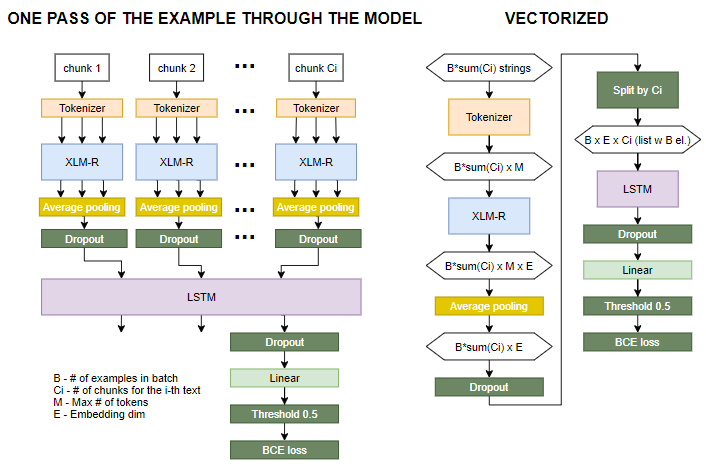

## Train functions



Define custom dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self,df):
        self.n_chunks = df['n_chunks'].to_list()
        self.X = df['Text'].to_list()
        self.Y = df['Label']
    def __len__(self):
        return len(self.X)
    def __getitem__(self,index):
        return self.X[index], self.Y.iloc[index], self.n_chunks[index]
def collate_func(batch):
    X = [x[0] for x in batch]
    Y = torch.Tensor([x[1] for x in batch])
    c = [x[2] for x in batch]
    return [X,Y,c]

In [ ]:
from sklearn.metrics import confusion_matrix

def train_step(train_loader, tokenize, device, optimizer,scheduler, xlmr, classifier,logs,pooled_emb_do):
    xlmr.train()
    classifier.train()
    iteration = 0
    acc_sum=0
    accuracy = []
    losses = []
    cms = []
    for text, target, n_chunks in train_loader:
        logs['lr'].append(get_lr(optimizer))
        target = target.to(device)
        flat_text = [item for sublist in text for item in sublist]
        tokens = tokenize(flat_text)
        tokens = tokens.to(device)
        embeddings = xlmr.extract_features(tokens)
        pooled_emb = torch.mean(embeddings, axis=1)
        pooled_emb = nn.Dropout(pooled_emb_do)(pooled_emb)
        # perform sum pooling
        x = [s for s in torch.split(pooled_emb, n_chunks,dim=0)]
        logit = classifier(x, n_chunks)
        prob = torch.sigmoid(logit)
        target = torch.reshape(target,shape=(-1,1))
        loss = nn.BCELoss()(input=prob, target=target.float())
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()
        # calculate accuracy
        prob = torch.squeeze(prob)
        prediction = torch.clone(prob)
        prediction[prediction >= 0.5] = 1
        prediction[prediction < 0.5] = 0
        target = torch.squeeze(target)
        acc = torch.sum(target==prediction)/float(len(target))
        accuracy.append(float(acc))
        losses.append(float(loss.detach().cpu().numpy()))
        # calculate confusion matrix
        cm = confusion_matrix(target.detach().cpu().numpy(),
                              prediction.detach().cpu().numpy(),
                              labels = np.array([0,1])
                              )
        cms.append(cm)
        iteration+=1
        print(f"\r iter: {iteration}/{len(train_loader)}",end='')
    return accuracy, losses, cms
def val_step(val_loader, tokenize, device, xlmr, classifier, is_test=False):
    print('')
    print('Validating...')
    xlmr.eval()
    classifier.eval()
    iteration = 0
    accuracy = []
    losses = []
    cms = []
    if is_test:
        predictions,targets = [],[]
    for text, target, n_chunks in val_loader:
        target = target.to(device)
        flat_text = [item for sublist in text for item in sublist]
        tokens = tokenize(flat_text)
        tokens = tokens.to(device)
        with torch.no_grad():
            embeddings = xlmr.extract_features(tokens)
            pooled_emb = torch.mean(embeddings, axis=1)
            # perform sum pooling
            x = [s for s in torch.split(pooled_emb, n_chunks,dim=0)]
            logit = classifier(x, n_chunks)
            prob = torch.sigmoid(logit)
        target = torch.reshape(target,shape=(-1,1))
        loss = nn.BCELoss()(input=prob, target=target.float())
        # calculate accuracy
        prob = torch.squeeze(prob)
        prediction = torch.clone(prob)
        prediction[prediction >= 0.5] = 1
        prediction[prediction < 0.5] = 0
        target = torch.squeeze(target)
        acc = torch.sum(target==prediction)/float(len(target))
        accuracy.append(float(acc))
        losses.append(float(loss.cpu().numpy()))
        # calculate confusion matrix
        cm = confusion_matrix(target.cpu().numpy(),
                              prediction.cpu().numpy(),
                              labels = np.array([0,1])
                              )
        cms.append(cm)
        iteration+=1
        print(f"\r iter: {iteration}/{len(val_loader)}",end='')
        if is_test:
            predictions.append(prediction.cpu().numpy())
            targets.append(target.cpu().numpy())
    if is_test:
        return accuracy, losses, cms, predictions, targets
    return accuracy, losses, cms

In [ ]:
def save_to_disk(txt_path, values):
    if os.path.isfile(txt_path):
        os.remove(txt_path)
    with open(txt_path, "wb") as fp:   
        pickle.dump(values, fp)
    return
def load_from_disk(txt_path):
    with open(txt_path, "rb") as f:
        values =  pickle.load(f)
    return values
def save_checkpoint(xlmr, classifier, optimizer, logs, checkpoint_dir, epoch):
    print('')
    print('Saving checkpoint...')
    state_dict = {
        'classifier':classifier.state_dict(),
        'optimizer': optimizer.state_dict(),
        'xlmr': xlmr.state_dict()
    }
    torch.save(state_dict, os.path.join(checkpoint_dir, 'checkpoint_{}.pt'.format(epoch)))
    save_to_disk(os.path.join(checkpoint_dir, 'logs.txt'),logs)
    print(f'Checkpoint saved!')
def load_checkpoint(checkpoint_dir, epoch, xlmr, classifier, device, optimizer=None):
    pretrained_dict = torch.load(os.path.join(checkpoint_dir,'checkpoint_{}.pt'.format(epoch)),map_location=torch.device(device))
    classifier.load_state_dict(pretrained_dict['classifier'])
    xlmr.load_state_dict(pretrained_dict['xlmr'])
    if optimizer is not None:
        optimizer.load_state_dict(pretrained_dict['optimizer'])
        return xlmr, classifier, optimizer
    return xlmr,classifier

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
class Classifier(nn.Module):
    def __init__(self, lstm_size, emb_dim, out_dim_lin, lstm_do):
        super().__init__()
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=lstm_size, batch_first=True)
        self.lstm_do = nn.Dropout(lstm_do)
        self.linear = nn.Linear(in_features=lstm_size, out_features=out_dim_lin)
    def forward(self, x, n_chunks):
        x = pad_sequence(x, batch_first=True, padding_value=0)
        x = pack_padded_sequence(input=x, lengths=n_chunks, batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = pad_packed_sequence(x, batch_first=True)
        x = x[:,-1,:]
        x = self.lstm_do(x)
        logit = self.linear(x)
        return logit

## Hyperparameters

In [ ]:
BATCH_SIZE = 2
#TOKEN_MAX_LEN = 512 or 354
EPOCHS = 100 # total number of epochs
LR = 1e-7
EMBEDDING_DIM = 768 # 768 for base and 1024 for large
LSTM_SIZE = 128
LSTM_DO = 0.2
POOLED_EMB_DO = 0.3
OUT_DIM_LIN = 1
WEIGHT_DECAY = 1e-3
#=============================
# freeze xlmr hyperparams 
EPOCHS_FREEZE = 2
NUM_WARMUP_EPOCHS_FREEZE = 1
LR_FREEZE = 6e-5
#=============================
LR_LIN = 3e-6
EPOCHS_LIN = 50

In [ ]:
# define Data Loaders
train_dataset = MyDataset(df_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_func)
val_dataset = MyDataset(df_val)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_func)
test_dataset = MyDataset(df_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_func)

## Train loop

In [ ]:
checkpoint_dir = os.path.join(os.getcwd(),'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Selected device is {}'.format(device))
xlmr = xlmr.to(device)
classifier = Classifier(lstm_size=LSTM_SIZE,
                        emb_dim=EMBEDDING_DIM,
                        out_dim_lin=OUT_DIM_LIN,
                        lstm_do = LSTM_DO
                        ).to(device)
print('Number of trainable params: ',sum(p.numel() for p in xlmr.parameters())+\
      sum(p.numel() for p in classifier.parameters()))
# define optimizer
params = list(xlmr.parameters()) + list(classifier.parameters())
# start with frozen XLMR model (it should be left in train mode)
for p in xlmr.parameters():
    p.requires_grad=False
optimizer = SGD(params, lr=LR_FREEZE, weight_decay=WEIGHT_DECAY)
# define learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=NUM_WARMUP_EPOCHS_FREEZE*len(train_loader),
    num_training_steps=EPOCHS_FREEZE*len(train_loader)
    )
# wrap tokenizer
tokenize = wrap_tokenizer(tokenizer)
logs = {'train_acc':[],'train_loss':[],
        'val_acc':[],'val_loss':[], 'lr':[],
        'train_cm':[],'val_cm':[]}
for epoch in range(EPOCHS):
    if epoch == EPOCHS_FREEZE:
        print('XLM-R model is unfrozen!')
        print(f'Learning rate is set to {LR_LIN}!')
        for p in xlmr.parameters():
             p.requires_grad=True
        optimizer = AdamW(params, lr=LR_LIN, weight_decay=WEIGHT_DECAY)
        scheduler = None
    if epoch == EPOCHS_FREEZE + EPOCHS_LIN:
        print(f'Learning rate is set to {LR}!')
        set_lr(optimizer, LR)
        scheduler = None
    train_acc, train_loss, train_cm = train_step(
        train_loader=train_loader,
        tokenize=tokenize, 
        device=device, 
        optimizer=optimizer, 
        scheduler=scheduler,
        xlmr=xlmr,
        classifier=classifier,
        logs=logs,
        pooled_emb_do = POOLED_EMB_DO
        )
    val_acc, val_loss, val_cm = val_step(
        val_loader=val_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier
        )
    logs['train_acc'] += train_acc
    logs['train_loss'] += train_loss
    logs['val_acc'] += val_acc
    logs['val_loss'] += val_loss
    logs['train_cm'] += train_cm
    logs['val_cm'] += val_cm 
    if epoch % 2 == 0 and epoch != 0 :
        save_checkpoint(
            xlmr=xlmr,
            classifier=classifier, 
            optimizer=optimizer, 
            logs=logs, 
            checkpoint_dir=checkpoint_dir, 
            epoch=epoch
            )
    print('')
    print(f"Epoch {epoch} --> loss:{mean(train_loss):.4f},\
        acc:{mean(train_acc):.2f}%,\
        val_loss:{mean(val_loss):.4f},\
        val_acc:{mean(val_acc):.2f}%\
        \ntrain_cm:\n {np.mean(train_cm, axis=0)}\
        \nval_cm:\n {np.mean(val_cm,axis=0)}\
        ")

In [ ]:
torch.cuda.empty_cache()

## Test

### Load pretrained weights

In [ ]:
import os
import pandas as pd
import numpy as np 
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

# load pretrained weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
checkpoint_dir = os.path.join(os.getcwd(),'checkpoints')
best_dir = os.path.join(checkpoint_dir,'best-MR')
classifier = Classifier(LSTM_SIZE,EMBEDDING_DIM, OUT_DIM_LIN, LSTM_DO)
xlmr, classifier = load_checkpoint(best_dir,16,xlmr,classifier,device)

### Load test set and pretrained weights

In [ ]:
# load test set
df_test = pd.read_csv(os.path.join(best_dir,'test.csv'))
df_test.drop(columns='Unnamed: 0', inplace=True)
df_test.Text = df_test.Text.apply(lambda x: literal_eval(x))
test_dataset = MyDataset(df_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_func)

### Test accuracy

In [ ]:
tokenize = wrap_tokenizer(tokenizer)
classifier = classifier.to(device)
xlmr = xlmr.to(device)
test_acc, test_loss,cms, predictions, targets = val_step(
        val_loader=test_loader,
        tokenize=tokenize, 
        device=device, 
        xlmr=xlmr,
        classifier=classifier,
        is_test=True
        )
print('')
print(f"test loss:{mean(test_loss):.4f}\n test acc:{mean(test_acc):.2f}%")


Validating...
 iter: 84/84
test loss:0.4466
 test acc:0.79%


State of the art result (86.11% cross-validation accuracy) for this task on the sam dataset can be found [here](https://scindeks-clanci.ceon.rs/data/pdf/1821-3251/2017/1821-32511702104B.pdf). I believe that this score can be achieved with better tweaking of hyperparameters (in which I have not invested much time) and XLM-R large model. Also you have to keep in mind that the test score depends on sentiment intensity of examples in the test set. This is shown below.

### Plot confusion matrix

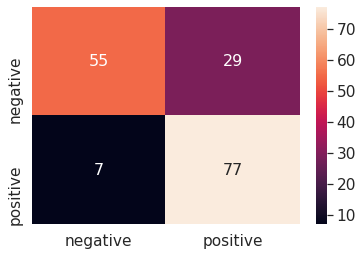

In [ ]:
preds = np.concatenate(predictions)
labels = np.concatenate(targets)

from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(labels, preds)
names = ['negative', 'positive']
df_cm = pd.DataFrame(cm, index=names, columns=names)
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

### Examine the influence of weak sentiment on wrong classification.

In [ ]:
# find the Scores in the original .csv file
df_orig = pd.read_csv(os.path.join(movies_path,'MR.csv'))
df_test['Mark'] = None
for i in range(len(df_test)):
    text = df_test.Text.iloc[i][0][:50]
    found = False
    for j in range(len(df_orig)):
        if text in df_orig.Text.iloc[j]:
            mark_id = df_test.columns.get_loc('Mark') 
            df_test.iloc[i,mark_id] = df_orig.Mark.iloc[j]
            found = True
            break  
    if not found:
        mark_id = df_test.columns.get_loc('Mark') 
        df_test.iloc[i,mark_id] = 0

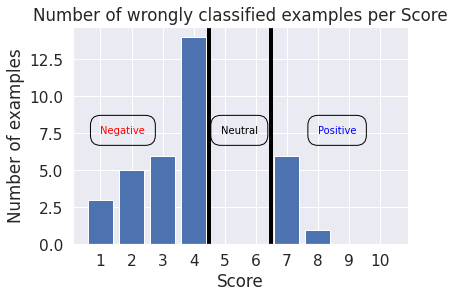

In [ ]:
height = df_test.loc[preds!=labels,'Mark'].value_counts()
height = height.to_dict()
values = np.arange(1,11)
for value in values:
    if value not in height.keys():
        height[value] = 0
del height[0]
plt.xlabel('Score')
plt.ylabel('Number of examples')
plt.xticks(values)
plt.title('Number of wrongly classified examples per Score')
plt.bar(height.keys(), height=height.values())
plt.axvline(x=4.5, linewidth=4, color='black')
plt.axvline(x=6.5, linewidth=4, color='black')
plt.text(8, 7.5, 'Positive', color='blue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
        fontsize=10)
plt.text(4.875, 7.5, 'Neutral', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
        fontsize=10)
plt.text(1, 7.5, 'Negative', color='red', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
        fontsize=10)
print('')

We can see that most of the wrongly classified examples have weak sentiment (score close to 5 and 6).

### Show training curves

In [ ]:
SHOW_EPOCHS = 17

logs = load_from_disk(os.path.join(best_dir,'logs.txt'))

In [ ]:
def average(data, frequency, start_avg_point=0):
    average_data = []
    if (len(data) > start_avg_point):
        round_num = -(len(str(frequency))-1)
        for i in range(0,round(len(data),round_num)-frequency,frequency):
            avg_data=mean(data[i:i+frequency])
            average_data.append(avg_data)
    return average_data

In [ ]:
train_acc = average(logs['train_acc'],677)[:SHOW_EPOCHS]
val_acc = average(logs['val_acc'],84)[:SHOW_EPOCHS]
lr = logs['lr'][:677*(SHOW_EPOCHS-1)]

Show accuracy through epochs

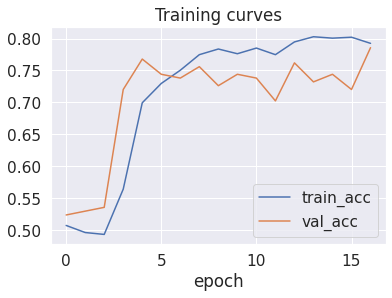

In [ ]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Training curves')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'])
print('')

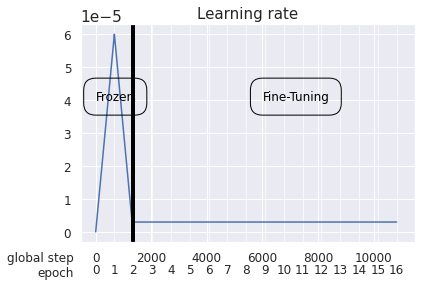

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(lr)
ax.set_title('Learning rate',fontsize=15)
minor_ticks = np.arange(-1, 677*SHOW_EPOCHS, 677)
ax.set_xticks(minor_ticks, minor=True)
ax.set_xticklabels(labels=range(0,17),minor=True)
ax.grid(which='minor', alpha=0.7)
xax = ax.get_xaxis()
ax.set_xlabel('global step\nepoch',labelpad=-25,horizontalalignment='right', x=-0.02, fontsize=12)
xax.set_tick_params(which='minor', pad=17,labelsize=12)
xax.set_tick_params(which='major',labelsize=12)
ax.get_yaxis().set_tick_params(labelsize=12)
ax.axvline(x=2*677, linewidth=4, color='black')
ax.text(0, 4e-5, 'Frozen', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
        fontsize=12)
ax.text(6000, 4e-5, 'Fine-Tuning', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'),
        fontsize=12)
print('')

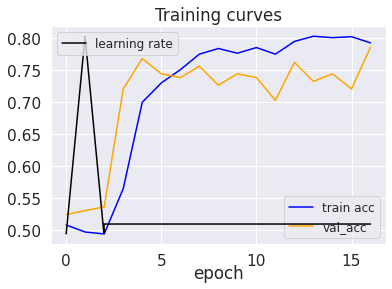

In [ ]:
fig = plt.figure()
ax1=fig.add_subplot(111, label="1")
l1,=ax1.plot(train_acc,color='blue')
l2,=ax1.plot(val_acc,color='orange')
ax1.legend(['train acc','val_acc'],loc='lower right',fontsize=12)
ax=fig.add_subplot(111, label="3",frame_on=False)
ax.plot(lr, color='black')
ax.set_title('Training curves')
#ax.set_xlabel('epoch')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.legend(['learning rate'],loc='upper left',fontsize=12)
plt.xlabel('epoch',labelpad=20)
print('')